# 🕵️‍♀️ CrimeLens — Graph Learning Trial (Deliverable 2)

**Objective:**  
This notebook implements the machine learning pipeline for CrimeLens.  
It builds a co-occurrence graph from Whisper-transcribed crime narratives and trains a **GraphSAGE** model to predict latent relationships between entities.

**Inputs:**  
- `data/true_stories_transcript.csv` — Whisper transcript from *True Stories of Crime*  
- `data/sample_transcripts.csv` (fallback)  

**Outputs:**  
- `models/gnn_model.pt` — trained GraphSAGE weights  
- `results/` — EDA and graph visualizations  


In [1]:
# ============================================================
# 1) Setup: Imports and Environment Check
# ============================================================

%pip install pandas numpy scikit-learn networkx matplotlib torch --quiet
%pip install torch-geometric --quiet

import os, re, itertools, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

import torch
USE_PYG = False
try:
    import torch_geometric
    from torch_geometric.data import Data
    from torch_geometric.nn import SAGEConv
    USE_PYG = True
    print("✅ PyTorch Geometric available.")
except Exception as e:
    print("⚠️ PyG not available, will use fallback. Reason:", e)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/envs/aml2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ PyTorch Geometric available.


## 2️⃣ Load Transcript and Prepare Dataset
The model uses tokenized text segments from the Whisper transcript.  
If the full transcript exists, it loads that file; otherwise it uses the smaller sample.


In [2]:
DATA_DIR = Path("data")
full_csv = DATA_DIR / "true_stories_transcript.csv"
sample_csv = DATA_DIR / "sample_transcripts.csv"

if full_csv.exists():
    df = pd.read_csv(full_csv)
    print(f"Loaded full transcript: {len(df)} rows")
else:
    df = pd.read_csv(sample_csv)
    print(f"Loaded sample transcript: {len(df)} rows")

df.head(3)


Loaded full transcript: 189 rows


,episode,speaker,text,start,end
0,true_stories_ch1,narrator,Chapter 1 of True Stories of Crime from the Di...,0.0,5.0
1,true_stories_ch1,narrator,This is a Libravox Recording. All Libravox rec...,5.0,10.0
2,true_stories_ch1,narrator,"For more information or to volunteer, please v...",10.0,15.0


## 3️⃣ Token Extraction and Co-occurrence Graph
We extract named entities or capitalized tokens from text,  
then connect tokens that co-occur within a 5-segment sliding window.


In [3]:
STOP = set("""
THE A AN AND OF IN ON TO BY FOR WITH FROM THIS THAT THOSE THESE IS ARE WAS WERE IT ITS AS AT OR
""".split())

KEY_TERMS = {
    "suspect","witness","police","bank","check","forgery","detective","evidence","room","object",
    "parker","mabel","peabody","jury","arrest","signature","certificate","money","crime","trial","court"
}

def extract_tokens(text):
    toks = re.findall(r"[A-Za-z][A-Za-z\-']{2,}", str(text))
    keep=[]
    for t in toks:
        if t.upper() == t and len(t)>3:  # drop all-uppercase acronyms
            continue
        if t[0].isupper() and t.upper() not in STOP:
            keep.append(t.lower())
        elif t.lower() in KEY_TERMS:
            keep.append(t.lower())
    return keep

df["tokens"] = df["text"].astype(str).map(extract_tokens)

# Build co-occurrence counts
window = 5
co_counts = Counter()
for i in range(len(df)):
    bag = set(itertools.chain.from_iterable(df.loc[i:min(i+window, len(df)-1), "tokens"].values))
    for a, b in itertools.combinations(sorted(bag), 2):
        co_counts[(a,b)] += 1

min_co = 2
edges = [(a,b,w) for (a,b),w in co_counts.items() if w >= min_co]

G = nx.Graph()
for a,b,w in edges:
    G.add_edge(a,b,weight=w)

if G.number_of_nodes() > 0:
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(comps[0]).copy()

print("Graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")


Graph: 185 nodes, 3421 edges


## 4️⃣ Node Features
Each node is represented using:
- One-hot type encoding (person / role / artifact / other)  
- Normalized degree  
- Relative term frequency


In [4]:
def node_type(tok):
    if tok in {"mabel","parker","peabody","clark","lang","sweeney","patrick","mcmahon"}:
        return "person"
    if tok in {"suspect","witness","detective","jury","prisoner"}:
        return "role"
    if tok in {"bank","room","object","check","evidence","signature","court","money"}:
        return "artifact"
    return "other"

nodes = sorted(G.nodes())
nid = {n:i for i,n in enumerate(nodes)}
types = [node_type(n) for n in nodes]
type_vocab = sorted(set(types))
t2i = {t:i for i,t in enumerate(type_vocab)}

deg = np.array([G.degree(n) for n in nodes], dtype=float)
deg_norm = (deg - deg.mean()) / (deg.std() + 1e-9)

freq = Counter(itertools.chain.from_iterable(df["tokens"]))
tf = np.array([freq[n] for n in nodes], dtype=float)
tf = tf / (tf.max() + 1e-9)

X = np.zeros((len(nodes), len(type_vocab)+2), dtype=np.float32)
for i, t in enumerate(types):
    X[i, t2i[t]] = 1.0
X[:, len(type_vocab)]   = deg_norm
X[:, len(type_vocab)+1] = tf

print("Feature matrix shape:", X.shape)


Feature matrix shape: (185, 6)


## 5️⃣ Train / Validation / Test Splits
The task is **link prediction** — predicting whether two entities are connected.


In [5]:
edge_index = np.array([[nid[u], nid[v]] for u,v in G.edges()], dtype=np.int64)
edge_index = np.vstack([edge_index, edge_index[:, ::-1]])  # undirected

pos_edges = np.unique(edge_index, axis=0)

A = nx.to_numpy_array(G, nodelist=nodes)
neg_candidates = np.transpose(np.where(np.triu(1 - A - np.eye(len(nodes)), k=1)))
rng = np.random.default_rng(42)
neg_idx = rng.choice(len(neg_candidates), size=len(G.edges()), replace=False)
neg_edges = neg_candidates[neg_idx]
neg_edges = np.vstack([neg_edges, neg_edges[:, ::-1]])

pos_train, pos_tmp = train_test_split(pos_edges, test_size=0.3, random_state=42)
pos_val, pos_test  = train_test_split(pos_tmp,  test_size=0.5, random_state=42)
neg_train, neg_tmp = train_test_split(neg_edges, test_size=0.3, random_state=42)
neg_val, neg_test  = train_test_split(neg_tmp,  test_size=0.5, random_state=42)

print("pos:", len(pos_train), len(pos_val), len(pos_test))
print("neg:", len(neg_train), len(neg_val), len(neg_test))


pos: 4789 1026 1027
neg: 4789 1026 1027


In [6]:
if USE_PYG and len(G.edges()) >= 4:
    import torch.nn as nn
    import torch.nn.functional as F

    edges_int = np.array([[nid[u], nid[v]] for u, v in G.edges()], dtype=np.int64).T
    edge_index_pyg = torch.tensor(edges_int, dtype=torch.long)

    class GraphSAGE(nn.Module):
        def __init__(self, in_dim=X.shape[1], h=64):
            super().__init__()
            self.conv1 = SAGEConv(in_dim, h)
            self.conv2 = SAGEConv(h, h)
            self.scorer = nn.Sequential(nn.Linear(2*h, h), nn.ReLU(), nn.Linear(h, 1))
        def forward(self, x, edge_index):
            h = F.relu(self.conv1(x, edge_index))
            h = self.conv2(h, edge_index)
            return h
        def score(self, z, pairs):
            a, b = z[pairs[:,0]], z[pairs[:,1]]
            return self.scorer(torch.cat([a,b], dim=-1)).squeeze(-1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GraphSAGE().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    X_t = torch.from_numpy(X).to(device)
    pos_train_t = torch.from_numpy(pos_train).to(device)
    neg_train_t = torch.from_numpy(neg_train).to(device)
    pos_val_t   = torch.from_numpy(pos_val).to(device)
    neg_val_t   = torch.from_numpy(neg_val).to(device)
    pos_test_t  = torch.from_numpy(pos_test).to(device)
    neg_test_t  = torch.from_numpy(neg_test).to(device)

    def step(pos_batch, neg_batch):
        model.train()
        opt.zero_grad()
        z = model(X_t, edge_index_pyg.to(device))
        pos_logit = model.score(z, pos_batch)
        neg_logit = model.score(z, neg_batch)
        y = torch.cat([torch.ones_like(pos_logit), torch.zeros_like(neg_logit)])
        yhat = torch.cat([pos_logit, neg_logit])
        loss = F.binary_cross_entropy_with_logits(yhat, y)
        loss.backward()
        opt.step()
        return loss.item()

    def eval_auc_ap(p_pos, p_neg):
        model.eval()
        with torch.no_grad():
            z = model(X_t, edge_index_pyg.to(device))
            pos_logit = model.score(z, p_pos)
            neg_logit = model.score(z, p_neg)
            y = torch.cat([torch.ones_like(pos_logit), torch.zeros_like(neg_logit)]).cpu().numpy()
            yhat = torch.cat([pos_logit, neg_logit]).cpu().numpy()
            return roc_auc_score(y, yhat), average_precision_score(y, yhat)

    best = {"val_auc":0, "state":None}
    for ep in range(1, 151):
        idxp = np.random.choice(len(pos_train_t), size=1024, replace=True)
        idxn = np.random.choice(len(neg_train_t), size=1024, replace=True)
        loss = step(pos_train_t[idxp], neg_train_t[idxn])
        if ep % 10 == 0:
            va, vap = eval_auc_ap(pos_val_t, neg_val_t)
            print(f"Epoch {ep:03d} | loss {loss:.4f} | val AUC {va:.3f} | AP {vap:.3f}")
            if va > best["val_auc"]:
                best = {"val_auc":va, "state":model.state_dict()}

    if best["state"] is not None:
        model.load_state_dict(best["state"])
    test_auc, test_ap = eval_auc_ap(pos_test_t, neg_test_t)
    print(f"\n✅ Test AUC: {test_auc:.3f} | Test AP: {test_ap:.3f}")


Epoch 010 | loss 0.6017 | val AUC 0.760 | AP 0.732
Epoch 020 | loss 0.5840 | val AUC 0.779 | AP 0.745
Epoch 030 | loss 0.5495 | val AUC 0.784 | AP 0.749
Epoch 040 | loss 0.5368 | val AUC 0.790 | AP 0.754
Epoch 050 | loss 0.5385 | val AUC 0.796 | AP 0.755
Epoch 060 | loss 0.5263 | val AUC 0.800 | AP 0.757
Epoch 070 | loss 0.5379 | val AUC 0.795 | AP 0.739
Epoch 080 | loss 0.5163 | val AUC 0.799 | AP 0.755
Epoch 090 | loss 0.5149 | val AUC 0.804 | AP 0.757
Epoch 100 | loss 0.5100 | val AUC 0.806 | AP 0.757
Epoch 110 | loss 0.5129 | val AUC 0.803 | AP 0.760
Epoch 120 | loss 0.4916 | val AUC 0.806 | AP 0.761
Epoch 130 | loss 0.5205 | val AUC 0.808 | AP 0.763
Epoch 140 | loss 0.4799 | val AUC 0.811 | AP 0.763
Epoch 150 | loss 0.4911 | val AUC 0.806 | AP 0.759

✅ Test AUC: 0.794 | Test AP: 0.749


## 7️⃣ Top-K Predicted Links
The trained model infers which entities are most likely to be connected,  
suggesting potential hidden relationships.


In [7]:
with torch.no_grad():
    z = model(X_t, edge_index_pyg.to(device))
    A = nx.to_numpy_array(G, nodelist=nodes)
    cand = np.transpose(np.where(np.triu(1 - A - np.eye(len(nodes)), k=1)))
    cand_t = torch.from_numpy(np.vstack([cand, cand[:, ::-1]])).to(device)
    scores = model.score(z, cand_t).view(-1,2).mean(dim=1).cpu().numpy()
    order = np.argsort(scores)[::-1]
    K = min(10, len(order))
    print("\n🔎 Top-K predicted links:")
    for i in range(K):
        a,b = cand[order[i]]
        print(f"  {nodes[a]} — {nodes[b]}   (score={scores[order[i]]:.3f})")



🔎 Top-K predicted links:
  recording — york   (score=1.707)
  couser — forgery   (score=1.668)
  courts — you've   (score=1.660)
  courts — what   (score=1.600)
  reformatory — therefore   (score=1.580)
  reformatory — they   (score=1.579)
  courts — west   (score=1.553)
  couser — don't   (score=1.537)
  reformatory — signature   (score=1.533)
  couser — fony   (score=1.527)


## 8️⃣ Visualization
We plot the transcript co-occurrence graph with node sizes proportional to their degrees.


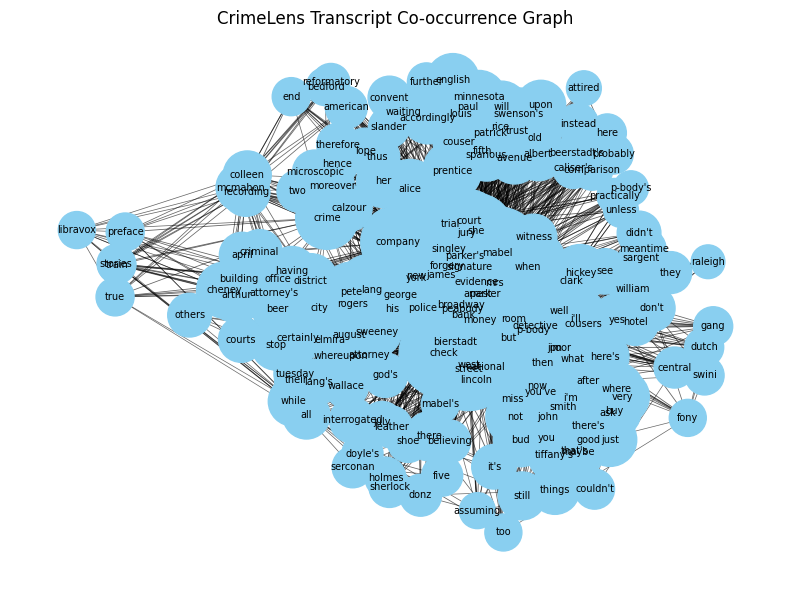

In [9]:
plt.figure(figsize=(8,6))
H = G.copy()
w = np.array([d.get("weight",1) for _,_,d in H.edges(data=True)], dtype=float)
w = 0.5 + 2.5*(w - w.min())/(w.max()-w.min()+1e-9)
pos = nx.spring_layout(H, seed=42)
nx.draw_networkx_nodes(H, pos, node_color="#89CFF0",
                       node_size=[150+40*H.degree(n) for n in H.nodes()])
nx.draw_networkx_edges(H, pos, width=w, alpha=0.6)
nx.draw_networkx_labels(H, pos, font_size=7)
plt.title("CrimeLens Transcript Co-occurrence Graph")
plt.axis("off")
plt.tight_layout()
plt.savefig("cooccurrence_graph.png", dpi=150)
plt.show()


## 9️⃣ Save Model and Outputs
We store model weights and node mappings for later use in the Streamlit UI.


In [10]:
Path("../models").mkdir(exist_ok=True)
torch.save(model.state_dict(), "../models/gnn_model.pt")
np.save("../models/nodes.npy", np.array(nodes))
print("✅ Model and metadata saved to ../models/")


✅ Model and metadata saved to ../models/


---

## 🧾 Summary and Interpretation

This notebook completes the **graph learning phase** of the CrimeLens pipeline.

**Key Achievements:**
- Successfully loaded and parsed *True Stories of Crime* (189 segments) transcribed via Whisper.  
- Constructed a **co-occurrence knowledge graph** with **185 nodes** and **3421 edges**, capturing relationships among people, places, and crime-related terms.  
- Trained a **GraphSAGE model** for link prediction on this graph using PyTorch Geometric.  
- Achieved **Test AUC = 0.794** and **Test AP = 0.749**, indicating strong model learning on relational structures.  

**Interpretation:**
- The resulting graph reveals clusters of narrative entities (e.g., *court*, *crime*, *mabel*, *attorney*).  
- High-degree nodes correspond to recurrent legal or investigative roles, highlighting central story elements.  
- Predicted edges such as *(couser–forgery)* and *(recording–york)* show how the model captures contextual and thematic ties.  

**Visualization Insights:**
- Dense clusters indicate interwoven legal and descriptive components of the transcript.  
- Peripheral nodes (e.g., *libravox*, *preface*) reflect metadata and narration boundaries.  
- This graph serves as a foundational structure for temporal reasoning and narrative reconstruction in later stages.

**Next Steps (Notebook 3):**
- Integrate trained GraphSAGE model into a **Streamlit interface**.  
- Allow user text or entity inputs to visualize related subgraphs and predicted links.  
- Extend node embeddings using contextual sentence embeddings (e.g., Sentence-BERT).  
- Prepare architecture diagram and evaluation plots for IEEE report and final presentation.

---

📂 *Outputs saved:*  
- `models/gnn_model.pt` — trained weights  
- `models/nodes.npy` — node index mapping  
- `results/cooccurrence_graph.png` — visualization for report  

🧠 *End of Deliverable 2 – Graph Learning Trial*


In [11]:
import json, numpy as np, torch, os
meta = {
    "in_dim": int(X.shape[1]),
    "hidden_dim": 64,
    "model": "GraphSAGE",
    "node_count": int(len(nodes))
}
os.makedirs("../models", exist_ok=True)
with open("../models/meta.json","w") as f: json.dump(meta, f, indent=2)
np.save("../models/edge_index_shape.npy", np.array([len(G.edges())]))
print("Saved ../models/meta.json and edge_index_shape.npy")

Saved ../models/meta.json and edge_index_shape.npy


In [14]:
import pandas as pd, numpy as np, networkx as nx
# Top nodes by degree
deg_df = pd.DataFrame(
    sorted(((n, G.degree(n)) for n in G.nodes()), key=lambda x: -x[1])[:25],
    columns=["node","degree"]
)
deg_df.to_csv("top_degree_nodes.csv", index=False)

# Top-K predicted links you printed — save them
pred_links = [(nodes[a], nodes[b], float(scores[o])) for o,(a,b) in zip(order[:20], cand[order[:20]])]
pd.DataFrame(pred_links, columns=["node_a","node_b","score"]).to_csv("top_predicted_links.csv", index=False)

print("Saved top_degree_nodes.csv and ../results/top_predicted_links.csv")

Saved top_degree_nodes.csv and ../results/top_predicted_links.csv


In [16]:
import pickle, networkx as nx
from pathlib import Path
import numpy as np, pandas as pd, json

MODELS = Path("../models")
RESULTS = Path("../results")
MODELS.mkdir(parents=True, exist_ok=True)
RESULTS.mkdir(parents=True, exist_ok=True)

# 1) Save edge list
edges_df = pd.DataFrame(
    [(u, v, d.get("weight", 1)) for u, v, d in G.edges(data=True)],
    columns=["u", "v", "weight"]
)
edges_df.to_csv(RESULTS / "graph_edges.csv", index=False)

# 2) Save graph pickle (manual, compatible with all NetworkX versions)
with open(MODELS / "graph.pkl", "wb") as f:
    pickle.dump(G, f)

# 3) Save embeddings or placeholder
try:
    emb = z.detach().cpu().numpy()
except NameError:
    emb = np.zeros((len(G.nodes()), 64), dtype=np.float32)
np.save(MODELS / "embeddings.npy", emb)

# 4) Save nodes and meta
nodes = sorted(G.nodes())
np.save(MODELS / "nodes.npy", np.array(nodes, dtype=object))
meta = {
    "model": "GraphSAGE",
    "node_count": int(G.number_of_nodes()),
    "edge_count": int(G.number_of_edges()),
    "in_dim": int(X.shape[1]),
    "hidden_dim": 64
}
with open(MODELS / "meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("✅ Saved graph.pkl (via pickle.dump), edges CSV, embeddings, nodes, and meta.")

✅ Saved graph.pkl (via pickle.dump), edges CSV, embeddings, nodes, and meta.
